In [33]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from gstatsMCMC import Topography_gpu
from gstatsMCMC import MCMC_gpu
import gstatsim as gs
from sklearn.preprocessing import QuantileTransformer
import skgstat as skg

In [34]:
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(device)

cuda


In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124

In [ ]:
import torch
# Should return True
print(torch.cuda.is_available())

# Should return a tensor on the GPU without error
print(torch.rand(10).cuda())

In [36]:
df = pd.read_csv('./data/BindSchalder_Macayeal_IceStreams.csv')
df.head(5)

,x,y,surf,bed,velx,vely,smb,dhdt,highvel_mask,bedmap_mask,bedmap_surf,bedmachine_source,bedmachine_thickness,bedmap_bed
0,-997250,-1056750,1995.0,NaN,3.154910,3.089999,0.188461,0.015527,False,1.0,1995.0,5.0,2013.206726,-68.0
1,-996750,-1056750,1991.0,NaN,2.865254,2.668077,0.187869,0.015527,False,1.0,1991.0,5.0,2003.393005,-65.0
2,-996250,-1056750,1989.0,NaN,3.341836,3.024601,0.187278,0.015527,False,1.0,1989.0,5.0,1992.894836,-60.0
3,-995750,-1056750,1988.0,NaN,3.897542,3.608380,0.186686,0.015527,False,1.0,1988.0,5.0,1983.685974,-54.0
4,-995250,-1056750,1987.0,NaN,3.632191,3.761807,0.186094,0.014805,False,1.0,1987.0,5.0,1974.599670,-49.0


In [37]:
x_uniq = np.unique(df.x)
y_uniq = np.unique(df.y)

xmin = np.min(x_uniq)
xmax = np.max(x_uniq)
ymin = np.min(y_uniq)
ymax = np.max(y_uniq)

cols = len(x_uniq)
rows = len(y_uniq)

resolution = 500

xx, yy = np.meshgrid(x_uniq, y_uniq)

In [38]:
# load other data
dhdt = df['dhdt'].values.reshape(xx.shape)
smb = df['smb'].values.reshape(xx.shape)
velx = df['velx'].values.reshape(xx.shape)
vely = df['vely'].values.reshape(xx.shape)
bedmap_mask = df['bedmap_mask'].values.reshape(xx.shape)
bedmachine_thickness = df['bedmachine_thickness'].values.reshape(xx.shape)
bedmap_surf = df['bedmap_surf'].values.reshape(xx.shape)
highvel_mask = df['highvel_mask'].values.reshape(xx.shape)
bedmap_bed = df['bedmap_bed'].values.reshape(xx.shape)

In [39]:
bedmachine_bed = bedmap_surf - bedmachine_thickness

In [40]:
cond_bed = np.where(bedmap_mask == 1, df['bed'].values.reshape(xx.shape), bedmap_bed)
df['cond_bed'] = cond_bed.flatten()

# create a mask of conditioning data
data_mask = ~np.isnan(cond_bed)

(np.float64(-997500.0),
 np.float64(-408500.0),
 np.float64(-1057000.0),
 np.float64(-550500.0))

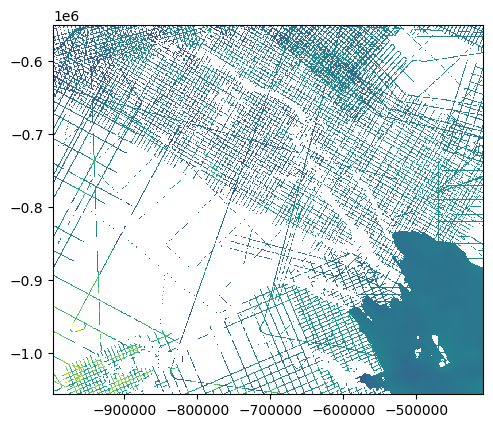

In [41]:
plt.pcolormesh(xx,yy,cond_bed)
plt.axis('scaled')

In [42]:
data = df['cond_bed'].values.reshape(-1,1)
nst_trans = QuantileTransformer(n_quantiles=500, output_distribution="normal",random_state=0).fit(data)
transformed_data = nst_trans.transform(data)
df['Nbed'] = transformed_data

In [43]:
data = df['cond_bed'].values.reshape(-1,1)
nst_trans = QuantileTransformer(n_quantiles=500, output_distribution="normal",random_state=0).fit(data)
transformed_data = nst_trans.transform(data)
df['Nbed'] = transformed_data

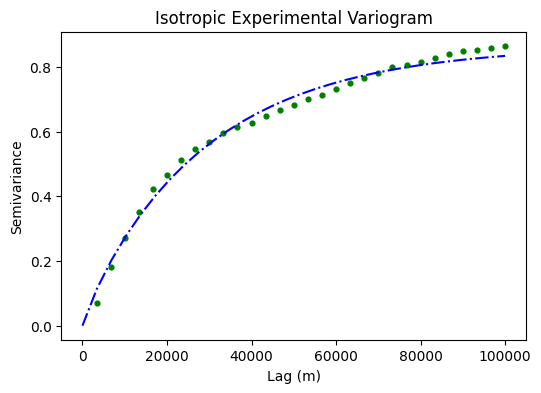

In [44]:
# randomly drop out 50% of coordinates. Decrease this value if you have a lot of data and it takes a long time to run
df_sampled = df.sample(frac=0.10, random_state=42)
df_sampled = df_sampled[df_sampled["cond_bed"].isnull() == False]
df_sampled = df_sampled[df_sampled["bedmap_mask"]==1]

# compute experimental (isotropic) variogram
coords = df_sampled[['x','y']].values
values = df_sampled['Nbed']

maxlag = 100000      # maximum range distance
n_lags = 30         # num of bins (try decreasing if this is taking too long)

# compute variogram
V1 = skg.Variogram(coords, values, bin_func='even', 
                   n_lags=n_lags, maxlag=maxlag, normalize=False, 
                   model='matern', samples = 0.4)

# extract variogram values
xdata = V1.bins
ydata = V1.experimental

V1_p = V1.parameters

# evaluate models
xi = np.linspace(0, xdata[-1], n_lags) 
y_mtn = [skg.models.matern(h, V1_p[0], V1_p[1], V1_p[2], V1_p[3]) for h in xi]
# variogram parameter is [range, sill, shape, nugget] for matern model.

plt.figure(figsize=(6,4))
plt.scatter(xdata, ydata, s=12, c='g')
plt.plot(xi, y_mtn,'b-.', label='Matern variogram model')
plt.title('Isotropic Experimental Variogram')
plt.xlabel('Lag (m)'); plt.ylabel('Semivariance')
plt.show()

In [45]:
V1_p

[np.float64(84174.40763909939),
 np.float64(0.8657897914055807),
 np.float64(0.4410297281989877),
 0]

In [46]:
sgs_bed = np.loadtxt('./sgs_beds/sgs_0_bindshadler_macayeal.txt')
thickness = bedmap_surf - sgs_bed
sgs_bed = np.where((thickness<=0)&(bedmap_mask==1), bedmap_surf-1, sgs_bed)

In [47]:
grounded_ice_mask = (bedmap_mask == 1)

In [48]:
largeScaleChain = MCMC_gpu.chain_crf(xx, yy, sgs_bed, bedmap_surf, velx, vely, dhdt, smb, cond_bed, data_mask, grounded_ice_mask, resolution)
cur_initial_bed_np = largeScaleChain.initial_bed.cpu().numpy()

before running the chain, please set where the block update will be using the object's function set_update_region(update_in_region, region_mask)
then please set up the loss function using either set_loss_type or set_loss_func
an RandField object also need to be created correctly and passed in set_crf_data_weight(RF) and in run(n_iter, RF)


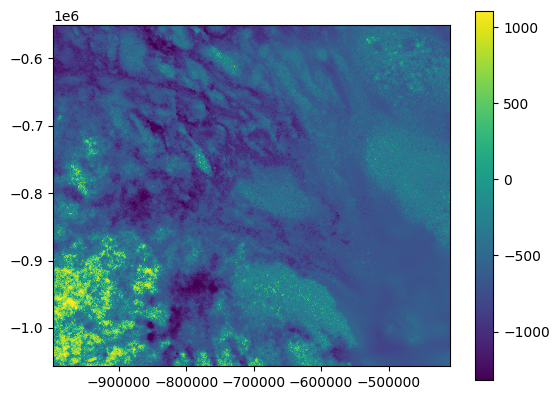

In [49]:

plt.pcolormesh(xx, yy, cur_initial_bed_np)
plt.axis('scaled')
plt.colorbar()

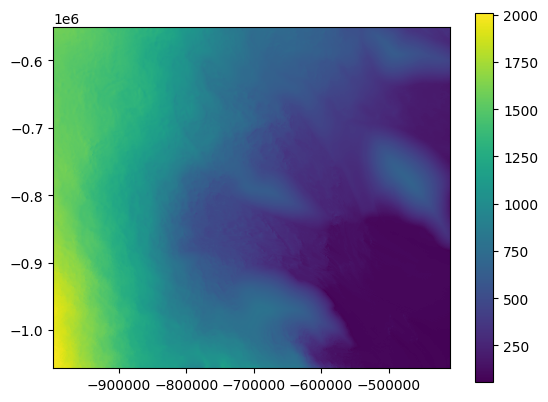

In [50]:
plt.pcolormesh(xx, yy, largeScaleChain.surf.cpu().numpy())
plt.axis('scaled')
plt.colorbar()

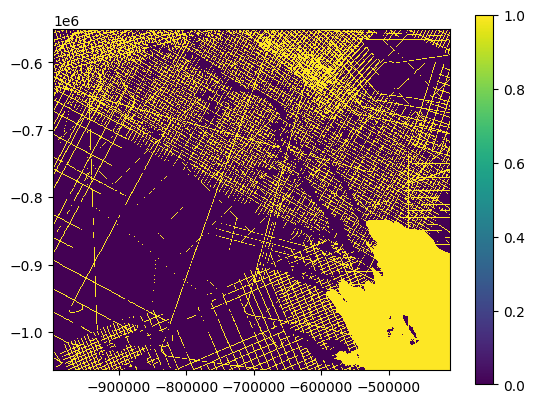

In [51]:
plt.pcolormesh(xx, yy, largeScaleChain.data_mask.cpu().numpy())
plt.axis('scaled')
plt.colorbar()

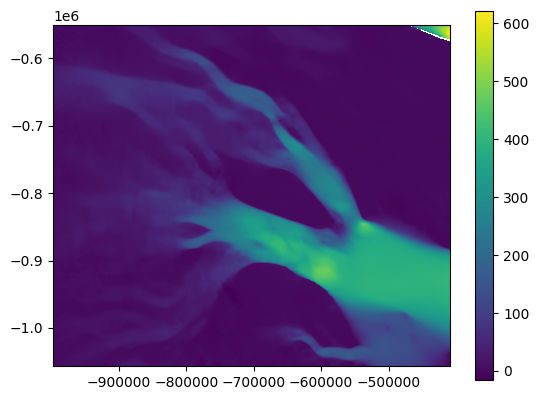

In [52]:
plt.pcolormesh(xx, yy, largeScaleChain.velx.cpu().numpy())
plt.axis('scaled')
plt.colorbar()

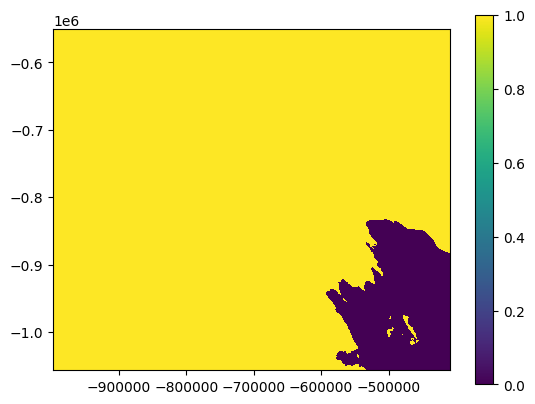

In [53]:
plt.pcolormesh(xx, yy, largeScaleChain.grounded_ice_mask.cpu().numpy())
plt.axis('scaled')
plt.colorbar()

In [54]:
largeScaleChain.set_update_region(True,highvel_mask)


the update blocks is set to be randomly generated for any locations inside the given region


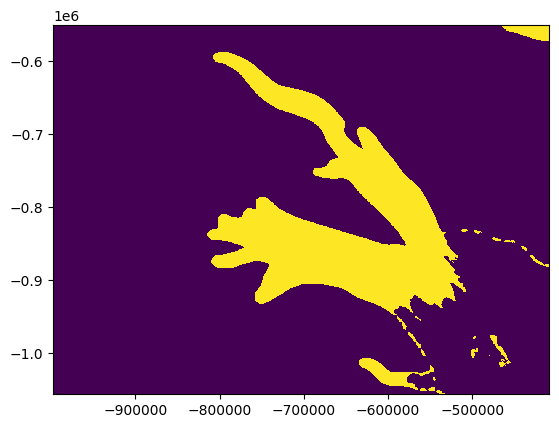

In [55]:
plt.pcolormesh(xx,yy,highvel_mask)

In [ ]:
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Version (PyTorch): {torch.version.cuda}")
print(f"GPU Name: {torch.cuda.get_device_name(0)}")
print(f"Compute Capability: {torch.cuda.get_device_capability(0)}")

PyTorch Version: 2.10.0+cu130
CUDA Version (PyTorch): 13.0
GPU Name: NVIDIA GeForce GTX 1070 Ti
Compute Capability: (6, 1)


In [56]:
mc_res_bm = Topography_gpu.get_mass_conservation_residual(bedmachine_bed,bedmap_surf,velx,vely,dhdt,smb,resolution)

AcceleratorError: CUDA error: no kernel image is available for execution on the device
Search for `cudaErrorNoKernelImageForDevice' in https://docs.nvidia.com/cuda/cuda-runtime-api/group__CUDART__TYPES.html for more information.
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [57]:
import config
sigma3 = config.sigma3
xl3=np.linspace(-100, 100, num=1000)
gaussian_model=1/(sigma3*np.sqrt(2*np.pi))*np.exp(-0.5*np.square(xl3/sigma3))

# here, we filter mc_res_bm to only account for mass flux residuals inside the high velocity region
mc_res_bm_sr2 = mc_res_bm[highvel_mask==1]
mc_res_bm_sr2_f = mc_res_bm_sr2.flatten()
mc_res_bm_sr2_f = mc_res_bm_sr2_f[~np.isnan(mc_res_bm_sr2_f)]

plt.hist(mc_res_bm_sr2_f, bins=5000, facecolor='red', alpha=0.3,density=True,label='BM')
plt.plot(xl3, gaussian_model, color='Green',alpha=0.6, label='Gaussian distribution')
plt.xlim([-50,50]);

plt.legend()
plt.xlabel('mass conv residual');
plt.ylabel('Frequency');
plt.title('histogram of mass conservation residual')
plt.show()

NameError: name 'mc_res_bm' is not defined